In [1]:
# pre trained vgg
!git clone https://github.com/neptune-ml/neptune-examples.git
!mv neptune-examples/data/vgg16_for_neural-style.ckpt  vgg16_convs.ckpt

!wget -O all.zip "https://storage.googleapis.com/kaggle-competitions-data/kaggle/3004/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1533645945&Signature=LvOqfmd7WOwNj%2BfLOg%2FqBFMvDgZddid2ZcJhtLBvJuxZwd5bZhAohtjZDgoOepILwuTN2V%2BkORBwHWYwtuDEXMjumG0nw8FJTrZaz2wXf2FsqIcN7v%2BcAWszEOjxXz31HIq1R8%2BAlargtMkCKPO1a8zLUqqpjqSvoYvaz2XeEp1OYQZQwwOTp7Q5Kfk1yPHinYDeLpcfJ%2BgZsRG8sEeYGiMdefYw6PhF4cPGmhIOoYHsnI8YGYSDwKZ2BAm6QLrEu7o7L3G8iBUsZHRsy7fNyhfgzeMylidZD0StDT%2FjXPjivuHhKR%2FEq3BTRYE2KUZG9azpnaMRhRFSAfs6i0vinw%3D%3D"
!unzip -o all.zip
!pip install imgaug

Cloning into 'neptune-examples'...
remote: Counting objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.
--2018-08-04 12:47:26--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/3004/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1533645945&Signature=LvOqfmd7WOwNj%2BfLOg%2FqBFMvDgZddid2ZcJhtLBvJuxZwd5bZhAohtjZDgoOepILwuTN2V%2BkORBwHWYwtuDEXMjumG0nw8FJTrZaz2wXf2FsqIcN7v%2BcAWszEOjxXz31HIq1R8%2BAlargtMkCKPO1a8zLUqqpjqSvoYvaz2XeEp1OYQZQwwOTp7Q5Kfk1yPHinYDeLpcfJ%2BgZsRG8sEeYGiMdefYw6PhF4cPGmhIOoYHsnI8YGYSDwKZ2BAm6QLrEu7o7L3G8iBUsZHRsy7fNyhfgzeMylidZD0StDT%2FjXPjivuHhKR%2FEq3BTRYE2KUZG9azpnaMRhRFSAfs6i0vinw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16054448 (15M) [app

In [0]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from imgaug import augmenters as iaa



In [3]:
channels = 3


def read_data():
    train_path = "train.csv"
    test_path = "test.csv"

    #train_path = "/kaggle/input/train.csv"
    #test_path = "/kaggle/input/test.csv"

    training_frame = pd.DataFrame(pd.read_csv(train_path))
    test_frame = pd.DataFrame(pd.read_csv(test_path))

    train_labels = np.array(training_frame['label'])
    col_names = ["pixel" + str(x) for x in range(784)]  # column names

    train_data = np.array(training_frame[col_names])
    train_data = np.repeat(train_data.reshape(train_data.shape[0], 28, 28, 1), channels, axis=3)

    test_data = np.array(test_frame[col_names])
    test_data = np.repeat(test_data.reshape(test_data.shape[0], 28, 28, 1), channels, axis=3)

    train_labels = (np.arange(10) == train_labels[:, None])

    return train_data.astype(np.float32), train_labels.astype(np.float32), test_data.astype(np.float32)


train_data, train_labels, test_data = read_data()

# shapes
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(42000, 28, 28, 3)
(42000, 10)
(28000, 28, 28, 3)


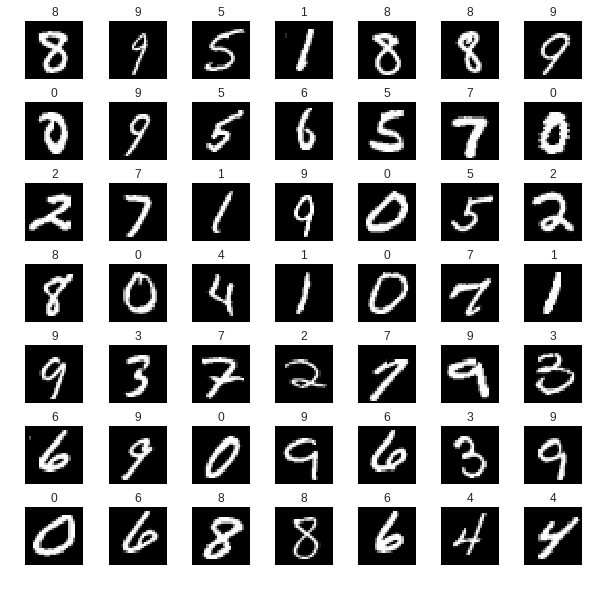

In [4]:


# preview raw data
def preview(data, labels):
    samples = random.sample(range(0, len(labels)), 7* 7)

    # 3 channels
    fig, axeslist = plt.subplots(ncols=7, nrows=7, figsize=(10, 10))

    for i, sample in enumerate(samples):
        axeslist.ravel()[i].imshow(data[sample].astype(np.uint8))
        axeslist.ravel()[i].set_title(np.argmax(labels[sample, :]))
        axeslist.ravel()[i].set_axis_off()
    
    plt.subplots_adjust(wspace=.4, hspace=.4)
    # single channel
    # _, axeslist2 = plt.subplots(ncols=5, nrows=5, figsize=(10, 10))

    # for i, sample in enumerate(samples):
    #    axeslist2.ravel()[i].imshow(data[sample, :, :, 0].astype(np.int32), cmap=plt.gray())
    #    axeslist2.ravel()[i].set_title(np.argmax(labels[sample, :]))
    #    axeslist2.ravel()[i].set_axis_off()


preview(train_data, train_labels)


(399000, 28, 28, 3)
(399000, 10)
(21000, 28, 28, 3)
(21000, 10)


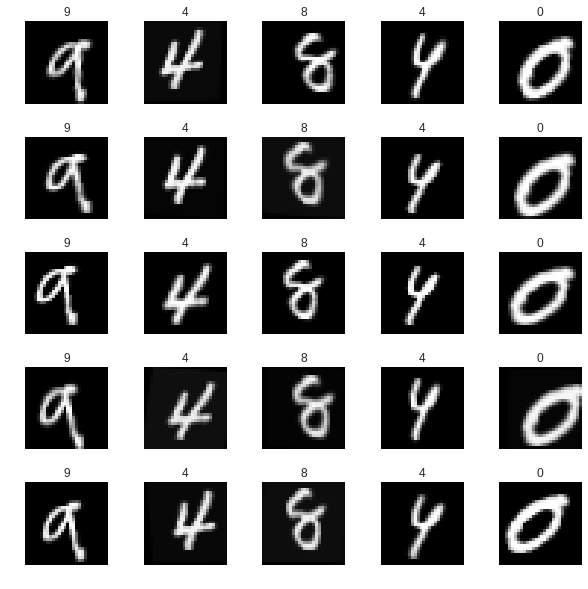

In [5]:


def augment_images(images, labels, aug_factor):
    seq = iaa.Sequential([
        # iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.025)),  # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.2,
                      iaa.GaussianBlur(sigma=(0, 0.1))
                      ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.85, 1.25)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01 * 255), per_channel=0.5),

        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        # iaa.Multiply((0.9, 1.1), per_channel=0.1),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-5, 5)
        )
    ])  # apply augmenters in random order

    augmented_images = np.concatenate([seq.augment_images(images) for _ in range(aug_factor)], axis=0)
    augmented_labels = np.concatenate([labels for _ in range(aug_factor)], axis=0)

    indeces = random.sample(range(0, images.shape[0]), 5)  # just random 5 elements
    indeces = [i * images.shape[0] + index for i in range(aug_factor) for index in indeces]  # corresponding augmentation

    fig, axeslist = plt.subplots(ncols=5, nrows=5, figsize=(10, 10))
    for i, index in enumerate(indeces):
        if i == 25:
            break
        axeslist.ravel()[i].imshow(augmented_images[index].astype(np.uint8))
        axeslist.ravel()[i].set_title(np.argmax(augmented_labels[index, :]))
        axeslist.ravel()[i].set_axis_off()
    
    plt.subplots_adjust(wspace=.4, hspace=.4)
    split = int(augmented_images.shape[0] * .95)

    augmented_images_train = augmented_images[:split]
    augmented_labels_train = augmented_labels[:split]

    augmented_images_valid = augmented_images[split:]
    augmented_labels_valid = augmented_labels[split:]

    permutation_train = np.random.permutation(augmented_images_train.shape[0])
    permutation_valid = np.random.permutation(augmented_images_valid.shape[0])

    return augmented_images_train[permutation_train], augmented_labels_train[permutation_train], augmented_images_valid[permutation_valid], augmented_labels_valid[permutation_valid]


augmented_images, augmented_labels, valid_images, valid_labels = augment_images(train_data, train_labels, 10)  # 10
# augment_images(np.array([train_data[:5]]).reshape((-1, 28, 28, 3)), np.array(train_labels[:5]).reshape((-1, 10)), 100, plot=True)

del train_data
del train_labels

print(augmented_images.shape)
print(augmented_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)

In [0]:
# tensorflow helpers
batch_size = 128
batch_size_valid = 200


def make_batch_resize(batch, batch_size):
    resized_batch = np.zeros((batch_size, 224, 224, 3))
    for i, image in enumerate(batch):
        resized_batch[i] = cv2.resize(image, (224, 224))

    return resized_batch

In [0]:
# Definition of the convolutional layer.
def conv2d(signal, num_outputs, kernel_size=[3, 3], stride=1, padding='SAME', activation_fn=tf.nn.relu, scope='Conv', trainable=False):
    num_inputs = int(signal.get_shape()[-1])  # input channels
    wshape = [kernel_size[0], kernel_size[1], num_inputs, num_outputs]  # conv shared weights
    stddev = np.sqrt(2. / (num_inputs * kernel_size[0] * kernel_size[1]))  # good initialization technique so the conv output nodes wont accumulate large values that will saturate neurons at the beginning
    with tf.variable_scope(scope):
        weights = tf.Variable(tf.truncated_normal(wshape, mean=0., stddev=stddev), dtype=tf.float32, name='weights', trainable=trainable)  # shared weight
        bias = tf.Variable(tf.constant(0., shape=[num_outputs]), dtype=tf.float32, name='bias', trainable=trainable)  # for each output channel
        signal = tf.nn.conv2d(signal, weights, strides=[1, stride, stride, 1], padding=padding)  # 1 for input images / 1 for channels
        signal = tf.nn.bias_add(signal, bias)
        signal = activation_fn(signal)
    return signal


# Definition of the average-pool layer.
def avg_pool(signal, kernel_size=[2, 2], stride=2, padding='SAME', name='AvgPool'):
    signal = tf.nn.avg_pool(signal, ksize=[1, kernel_size[0], kernel_size[1], 1], strides=[1, stride, stride, 1], padding=padding, name=name)
    return signal


In [0]:
tf_batch_images = tf.placeholder(tf.float32, shape=[None, 224, 224, 3], name='inputs')
tf_batch_labels = tf.placeholder(tf.int32, shape=[None, 10], name='labels')
tf_keep_prop = tf.placeholder(tf.float32, name='keep_prop')

# zero-mean input
with tf.name_scope('preprocess') as scope:
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    images = tf_batch_images - mean

# not trainable
conv1_1 = conv2d(images, 64, scope='conv1_1', trainable=False)
conv1_2 = conv2d(conv1_1, 64, scope='conv1_2', trainable=False)
pool1 = avg_pool(conv1_2, name='pool1')

conv2_1 = conv2d(pool1, 128, scope='conv2_1', trainable=False)
conv2_2 = conv2d(conv2_1, 128, scope='conv2_2', trainable=False)
pool2 = avg_pool(conv2_2, name='pool2')

conv3_1 = conv2d(pool2, 256, scope='conv3_1')
conv3_2 = conv2d(conv3_1, 256, scope='conv3_2', trainable=False)
conv3_3 = conv2d(conv3_2, 256, scope='conv3_3', trainable=False)
pool3 = avg_pool(conv3_3, name='pool3')

conv4_1 = conv2d(pool3, 512, scope='conv4_1')
conv4_2 = conv2d(conv4_1, 512, scope='conv4_2', trainable=False)
conv4_3 = conv2d(conv4_2, 512, scope='conv4_3', trainable=False)
pool4 = avg_pool(conv4_3, name='pool4')

conv5_1 = conv2d(pool4, 512, scope='conv5_1', trainable=False)
conv5_2 = conv2d(conv5_1, 512, scope='conv5_2', trainable=False)
conv5_3 = conv2d(conv5_2, 512, scope='conv5_3', trainable=False)
pool5 = avg_pool(conv5_3, name='pool5')

shape = pool5.get_shape().as_list()
reshape = tf.reshape(pool5, [-1, shape[1] * shape[2] * shape[3]])

# trainable
hidden = tf.layers.dense(reshape, units=512, use_bias=True, activation=tf.nn.relu)
hidden_dropout = tf.nn.dropout(hidden, tf_keep_prop)

hidden2 = tf.layers.dense(hidden_dropout, units=512, use_bias=True, activation=tf.nn.relu)
hidden_dropout2 = tf.nn.dropout(hidden2, tf_keep_prop)

logits = tf.layers.dense(hidden_dropout2, units=10, use_bias=True)
predictions = tf.cast(tf.argmax(logits, axis=1), tf.int32)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_batch_labels))

update = tf.train.AdamOptimizer(0.00005).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.cast(tf.argmax(tf_batch_labels, axis=1), tf.int32)), dtype=tf.float32))

vgg16 = tf.train.Saver(tf.global_variables()[:26])  # i need to restore only conv layers
mnist_vgg = tf.train.Saver()  # for the whole system


INFO:tensorflow:Restoring parameters from vgg16_convs.ckpt
Minibatch loss at step 0: 3.652406
Minibatch accuracy: 0.10938%
Minibatch loss at step 50: 0.602880
Minibatch accuracy: 0.82812%
Minibatch loss at step 100: 0.361358
Minibatch accuracy: 0.89844%
Minibatch loss at step 150: 0.332489
Minibatch accuracy: 0.86719%
Minibatch loss at step 200: 0.258959
Minibatch accuracy: 0.92969%
Minibatch loss at step 250: 0.151994
Minibatch accuracy: 0.93750%
Minibatch loss at step 300: 0.181978
Minibatch accuracy: 0.94531%
Minibatch loss at step 350: 0.109432
Minibatch accuracy: 0.96094%
Minibatch loss at step 400: 0.123277
Minibatch accuracy: 0.97656%
Minibatch loss at step 450: 0.150459
Minibatch accuracy: 0.94531%
Minibatch loss at step 500: 0.091664
Minibatch accuracy: 0.96094%
Minibatch loss at step 550: 0.079544
Minibatch accuracy: 0.97656%
Minibatch loss at step 600: 0.062303
Minibatch accuracy: 0.97656%
Minibatch loss at step 650: 0.069775
Minibatch accuracy: 0.98438%
Minibatch loss at st

Minibatch loss at step 2650: 0.033406
Minibatch accuracy: 0.98438%
Minibatch loss at step 2700: 0.037993
Minibatch accuracy: 0.98438%
Minibatch loss at step 2750: 0.036155
Minibatch accuracy: 0.99219%
Minibatch loss at step 2800: 0.038261
Minibatch accuracy: 0.99219%
Minibatch loss at step 2850: 0.068318
Minibatch accuracy: 0.97656%
Minibatch loss at step 2900: 0.010102
Minibatch accuracy: 1.00000%
Minibatch loss at step 2950: 0.022237
Minibatch accuracy: 0.99219%
Minibatch loss at step 3000: 0.045325
Minibatch accuracy: 0.98438%
Minibatch loss at step 3050: 0.011322
Minibatch accuracy: 0.99219%
Minibatch loss at step 3100: 0.013289
Minibatch accuracy: 1.00000%
epoch  0
average loss : 0.012562
average accuracy: 0.99625%
Minibatch loss at step 0: 0.035328
Minibatch accuracy: 0.99219%
Minibatch loss at step 50: 0.057057
Minibatch accuracy: 0.98438%
Minibatch loss at step 100: 0.007351
Minibatch accuracy: 1.00000%
Minibatch loss at step 150: 0.016097
Minibatch accuracy: 0.99219%
Minibatch

Minibatch loss at step 2150: 0.017077
Minibatch accuracy: 1.00000%
Minibatch loss at step 2200: 0.010979
Minibatch accuracy: 1.00000%
Minibatch loss at step 2250: 0.030963
Minibatch accuracy: 0.98438%
Minibatch loss at step 2300: 0.018832
Minibatch accuracy: 0.99219%
Minibatch loss at step 2350: 0.027820
Minibatch accuracy: 0.99219%
Minibatch loss at step 2400: 0.003002
Minibatch accuracy: 1.00000%
Minibatch loss at step 2450: 0.003034
Minibatch accuracy: 1.00000%
Minibatch loss at step 2500: 0.028069
Minibatch accuracy: 0.98438%
Minibatch loss at step 2550: 0.006253
Minibatch accuracy: 1.00000%
Minibatch loss at step 2600: 0.012414
Minibatch accuracy: 0.99219%
Minibatch loss at step 2650: 0.021886
Minibatch accuracy: 0.99219%
Minibatch loss at step 2700: 0.013433
Minibatch accuracy: 1.00000%
Minibatch loss at step 2750: 0.041256
Minibatch accuracy: 0.98438%
Minibatch loss at step 2800: 0.005378
Minibatch accuracy: 1.00000%
Minibatch loss at step 2850: 0.022070
Minibatch accuracy: 0.98

Minibatch loss at step 1650: 0.001109
Minibatch accuracy: 1.00000%
Minibatch loss at step 1700: 0.007395
Minibatch accuracy: 0.99219%
Minibatch loss at step 1750: 0.030109
Minibatch accuracy: 0.98438%
Minibatch loss at step 1800: 0.006276
Minibatch accuracy: 1.00000%
Minibatch loss at step 1850: 0.000124
Minibatch accuracy: 1.00000%
Minibatch loss at step 1900: 0.002634
Minibatch accuracy: 1.00000%
Minibatch loss at step 1950: 0.025563
Minibatch accuracy: 0.99219%
Minibatch loss at step 2000: 0.011674
Minibatch accuracy: 0.99219%
Minibatch loss at step 2050: 0.004381
Minibatch accuracy: 1.00000%
Minibatch loss at step 2100: 0.001740
Minibatch accuracy: 1.00000%
Minibatch loss at step 2150: 0.023139
Minibatch accuracy: 0.99219%
Minibatch loss at step 2200: 0.000647
Minibatch accuracy: 1.00000%
Minibatch loss at step 2250: 0.021183
Minibatch accuracy: 0.99219%
Minibatch loss at step 2300: 0.000784
Minibatch accuracy: 1.00000%
Minibatch loss at step 2350: 0.001291
Minibatch accuracy: 1.00

Minibatch loss at step 1150: 0.001591
Minibatch accuracy: 1.00000%
Minibatch loss at step 1200: 0.005819
Minibatch accuracy: 0.99219%
Minibatch loss at step 1250: 0.002379
Minibatch accuracy: 1.00000%
Minibatch loss at step 1300: 0.001905
Minibatch accuracy: 1.00000%
Minibatch loss at step 1350: 0.002256
Minibatch accuracy: 1.00000%
Minibatch loss at step 1400: 0.001596
Minibatch accuracy: 1.00000%
Minibatch loss at step 1450: 0.003084
Minibatch accuracy: 1.00000%
Minibatch loss at step 1500: 0.001007
Minibatch accuracy: 1.00000%
Minibatch loss at step 1550: 0.017779
Minibatch accuracy: 0.99219%
Minibatch loss at step 1600: 0.000509
Minibatch accuracy: 1.00000%
Minibatch loss at step 1650: 0.004401
Minibatch accuracy: 1.00000%
Minibatch loss at step 1700: 0.000905
Minibatch accuracy: 1.00000%
Minibatch loss at step 1750: 0.002156
Minibatch accuracy: 1.00000%
Minibatch loss at step 1800: 0.022493
Minibatch accuracy: 0.99219%
Minibatch loss at step 1850: 0.003357
Minibatch accuracy: 1.00

Minibatch loss at step 650: 0.002983
Minibatch accuracy: 1.00000%
Minibatch loss at step 700: 0.003632
Minibatch accuracy: 1.00000%
Minibatch loss at step 750: 0.002081
Minibatch accuracy: 1.00000%
Minibatch loss at step 800: 0.000088
Minibatch accuracy: 1.00000%
Minibatch loss at step 850: 0.011261
Minibatch accuracy: 0.99219%
Minibatch loss at step 900: 0.001302
Minibatch accuracy: 1.00000%
Minibatch loss at step 950: 0.000175
Minibatch accuracy: 1.00000%
Minibatch loss at step 1000: 0.000332
Minibatch accuracy: 1.00000%
Minibatch loss at step 1050: 0.009524
Minibatch accuracy: 0.99219%
Minibatch loss at step 1100: 0.011563
Minibatch accuracy: 0.99219%
Minibatch loss at step 1150: 0.003639
Minibatch accuracy: 1.00000%
Minibatch loss at step 1200: 0.000663
Minibatch accuracy: 1.00000%
Minibatch loss at step 1250: 0.000796
Minibatch accuracy: 1.00000%
Minibatch loss at step 1300: 0.001214
Minibatch accuracy: 1.00000%
Minibatch loss at step 1350: 0.000782
Minibatch accuracy: 1.00000%
Mi

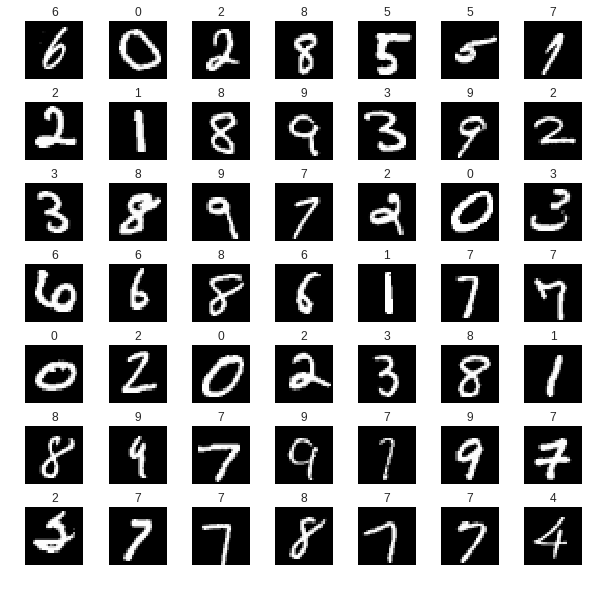

In [10]:
# small data to check
# augmented_images = augmented_images[:1000]
# augmented_labels = augmented_labels[:1000]
epochs = 5
labels_predicted = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # https://github.com/neptune-ml/neptune-examples.git
    # vgg16.restore(sess, '/media/mohammed/Core/preferences/jetBrains/pycharm/Graduation Project/OnVGG/data/vgg16_convs.ckpt')
    vgg16.restore(sess, 'vgg16_convs.ckpt')

    for epoch in range(epochs):
        for step, index in enumerate(range(0, augmented_images.shape[0] - batch_size, batch_size)):
            if step % 50 == 0:
                _, ls, acc = sess.run([update, loss, accuracy], feed_dict={tf_batch_images: make_batch_resize(augmented_images[index:index + batch_size], batch_size), tf_batch_labels: augmented_labels[index:index + batch_size], tf_keep_prop: .5})

                print('Minibatch loss at step %d: %f' % (step, ls))
                print('Minibatch accuracy: %.5f%%' % acc)

            else:
                sess.run(update, feed_dict={tf_batch_images: make_batch_resize(augmented_images[index:index + batch_size], batch_size), tf_batch_labels: augmented_labels[index:index + batch_size], tf_keep_prop: .5})

        tot_ls = 0
        tot_acc = 0
        cnt = 0
        for step, index in enumerate(range(0, valid_images.shape[0] - batch_size_valid, batch_size_valid)):
            ls, acc = sess.run([loss, accuracy], feed_dict={tf_batch_images: make_batch_resize(valid_images[index:index + batch_size_valid], batch_size_valid), tf_batch_labels: valid_labels[index:index + batch_size_valid], tf_keep_prop: 1})
            tot_ls += ls
            tot_acc += acc
            cnt += 1

        print("epoch ", epoch)
        print('average loss : %f' % (tot_ls / cnt))
        print('average accuracy: %.5f%%' % (tot_acc / cnt))

    for step, index in enumerate(range(0, test_data.shape[0], batch_size_valid)):
        preds = sess.run(predictions, feed_dict={tf_batch_images: make_batch_resize(test_data[index:index + batch_size_valid], batch_size_valid), tf_keep_prop: 1})
        labels_predicted.extend(list(preds))

    df = pd.DataFrame({'ImageId': range(1, 28001), 'Label': labels_predicted})
    df.to_csv("sub.csv", index=False)

    labels_predicted = np.array(labels_predicted)
    labels_predicted = (np.arange(10) == labels_predicted[:, None])
    preview(test_data, labels_predicted)
    #mnist_vgg.save(sess, 'mnist.ckpt')


In [0]:
from google.colab import files
files.download("sub.csv")